# Homework 2 solutions

We want to integrate the Planck function with a filter transmission profile to get a flux through the filter and then compute colors for stars.

Specifically, we want to do:

$$f_X \approx \int_0^\infty B_\lambda(T) s_X(\lambda) d\lambda$$

and then

$$B - V = -2.5 \log_{10}(f_B/f_V)$$

where our filter is just a step function:

   $$s_X(\lambda) = \left \{ \begin{array}{cc} 1 & |\lambda - \lambda_{0,X}| \le  \frac{d\lambda_X}{2} \\
                                               0 & \mbox{otherwise} \end{array} \right . $$

In [1]:
import numpy as np
import matplotlib.pyplot as plt

Let's start by defining the Planck function.  We'll work in CGS units (unlike in class where we made this dimensionless).

In [2]:
def B(lam, T=1.e4):
    """Planck function.  Here lambda is wavelength in cm, T is temperature in K"""
    k = 1.38e-16
    h = 6.63e-27
    c = 3.e10
    # we need to take the limit x -> 0 if the input x is 0
    return np.where(lam == 0, 0, 2 * h * c**2 / lam**5 / np.expm1(h*c/(lam*k*T)))

Let's just make sure that our $B(\lambda)$ looks like it should.  For $T = 10^4~\mathrm{K}$, it should peak in the visible.

/tmp/ipykernel_801389/1287262211.py:7: RuntimeWarning: overflow encountered in expm1
  return np.where(lam == 0, 0, 2 * h * c**2 / lam**5 / np.expm1(h*c/(lam*k*T)))


Text(0, 0.5, '$B(\\lambda)$')

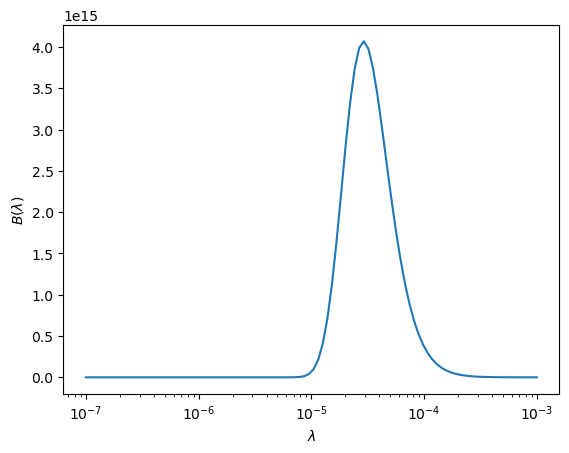

In [3]:
fig, ax = plt.subplots()
T = 1.e4
lam = np.logspace(-7, -3, 100)
ax.plot(lam, B(lam, T))
ax.set_xscale("log")
ax.set_xlabel(r"$\lambda$")
ax.set_ylabel(r"$B(\lambda)$")

Now let's define the filters (I'll include U here for fun).  This stores $\lambda_0$ and $d\lambda$ for each filter in a `dict` keyed on the filter name.

In [11]:
filters = {"U": (365e-7, 70e-7),
           "B": (445e-7, 90e-7),
           "V": (550e-7, 90e-7)}

Next, we'll write a function that computes the filter's response.

In [12]:
def filter_response(lam, lambda0, dlambda=50e-7):
    return np.where(np.logical_and(lam > lambda0-0.5*dlambda, lam < lambda0+0.5*dlambda), 1.0, 0.0)

and then a function that combines the filter and the Planck function --- this will be our integrand.

```{note}
I use a `*` here on the tuple that holds the filter parameters---this is an example of the [python unpacking operator](https://docs.python.org/3/tutorial/controlflow.html#tut-unpacking-arguments).
```

In [13]:
def filtered_B(lam, T=1.e4, filter="B"):
    return B(lam, T=T) * filter_response(lam, *filters[filter])

Now let's plot this filtered Planck function to see what it looks like.

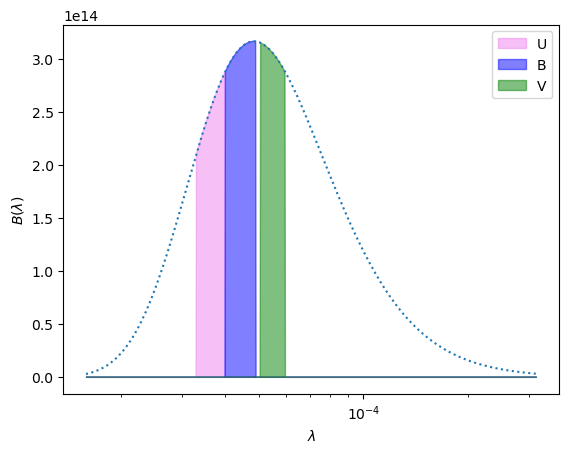

In [14]:
T = 6000

lam = np.logspace(-4.8, -3.5, 1000)

fig, ax = plt.subplots()
ax.fill(lam, filtered_B(lam, T=T, filter="U"), label="U", color="violet", alpha=0.5)
ax.fill(lam, filtered_B(lam, T=T, filter="B"), label="B", color="blue", alpha=0.5)
ax.fill(lam, filtered_B(lam, T=T, filter="V"), label="V", color="green", alpha=0.5)
ax.plot(lam, B(lam, T=T), ls=":")
ax.set_xscale("log")
ax.set_xlabel(r"$\lambda$")
ax.set_ylabel(r"$B(\lambda)$")
ax.legend()

We have different options for doing the integrals.  Since our $s(x)$ is just a step function, we actually need to just integrate:

$$f_X \approx \int_{\lambda_{0,X} - d\lambda+X/2}^{\lambda_{0,X} + d\lambda+X/2} B_\lambda(T) s_X(\lambda) d\lambda$$

so we don't need to use the machinery we developed in class for dealing with integrals to $\infty$.

I'll still use that here though, just because we might want to consider a different filter someday...

Let's define the transform functions and a composite trapezoid rule that works with them:

In [15]:
SMALL = 1.e-30

def zv(x, alpha=1):
    """ transform the variable x -> z """
    return x/(alpha + x) 

def xv(z, alpha=1):
    """ transform back from z -> x """
    return alpha*z/(1.0 - z + SMALL)

In [16]:
def I_t(func, N=10, alpha=5, args=None):
    """composite trapezoid rule for integrating from [0, oo].
    Here N is the number of intervals"""

    if args is None:
        args = ()
        
    # there are N+1 points corresponding to N intervals
    z = np.linspace(0.0, 1.0, N+1, endpoint=True)
    
    I = 0.0
    for n in range(N):
        I += 0.5 * (z[n+1] - z[n]) * (func(xv(z[n], alpha), *args) / (1.0 - z[n] + SMALL)**2 +
                                      func(xv(z[n+1], alpha), *args) / (1.0 - z[n+1] + SMALL)**2)
    I *= alpha
    return I

Now, we want to compute the zero-point of $B-V$ as that of a $T = 10^4~\mathrm{K}$ star.  We'll call this `BV0`:

In [17]:
T = 10000
BV0 = -2.5*np.log10(I_t(filtered_B, N=250, alpha=filters["B"][0], args=(T, "B")) /
                    I_t(filtered_B, N=250, alpha=filters["V"][0], args=(T, "V")))

/tmp/ipykernel_801389/1287262211.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  return np.where(lam == 0, 0, 2 * h * c**2 / lam**5 / np.expm1(h*c/(lam*k*T)))
/tmp/ipykernel_801389/1287262211.py:7: RuntimeWarning: invalid value encountered in scalar divide
  return np.where(lam == 0, 0, 2 * h * c**2 / lam**5 / np.expm1(h*c/(lam*k*T)))
/tmp/ipykernel_801389/1287262211.py:7: RuntimeWarning: overflow encountered in expm1
  return np.where(lam == 0, 0, 2 * h * c**2 / lam**5 / np.expm1(h*c/(lam*k*T)))


Finally, let's compute all of the $B-V$ for different $T$, making sure to correct with `BV0`:

In [18]:
Ts = np.logspace(np.log10(4000), np.log10(30000), 25)
BVs = []

for T in Ts:
    BV = -2.5*np.log10(I_t(filtered_B, N=250,
                           alpha=filters["B"][0], args=(T, "B")) /
                       I_t(filtered_B, N=250,
                           alpha=filters["V"][0], args=(T, "V"))) - BV0
    BVs.append(BV)

/tmp/ipykernel_801389/1287262211.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  return np.where(lam == 0, 0, 2 * h * c**2 / lam**5 / np.expm1(h*c/(lam*k*T)))
/tmp/ipykernel_801389/1287262211.py:7: RuntimeWarning: invalid value encountered in scalar divide
  return np.where(lam == 0, 0, 2 * h * c**2 / lam**5 / np.expm1(h*c/(lam*k*T)))
/tmp/ipykernel_801389/1287262211.py:7: RuntimeWarning: overflow encountered in expm1
  return np.where(lam == 0, 0, 2 * h * c**2 / lam**5 / np.expm1(h*c/(lam*k*T)))


Text(0, 0.5, '$B-V$')

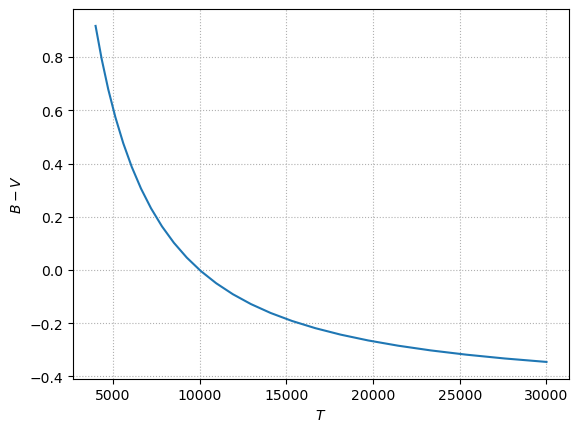

In [19]:
fig, ax = plt.subplots()
ax.plot(Ts, BVs)
ax.grid(ls=":")
ax.set_xlabel("$T$")
ax.set_ylabel("$B-V$")

 and we'll add points for real stars

In [20]:
stars = [("B0", 30000, -0.30),
         ("A0", 9520, -0.02),
         ("F0", 7200, +0.30),
         ("G0", 6030, +0.58),
         ("K0", 5250, +0.81),
         ("M0", 3850, +1.40)]

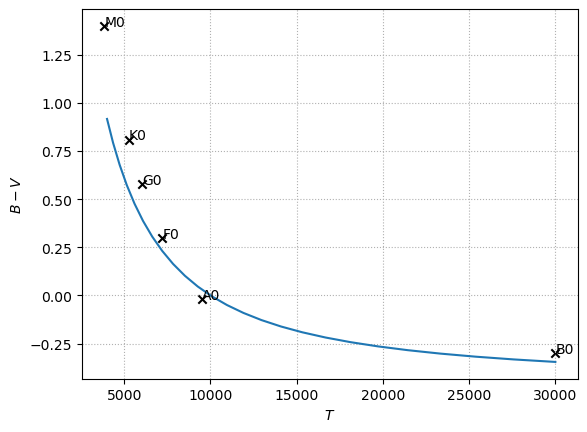

In [21]:
for l, T, BV in stars:
    ax.scatter(T, BV, marker="x", color="k")
    ax.text(T, BV, l)
fig

```{caution}
You may have thought that you could just use `scipy.integrate.quad` to do the
integration from $[0, \infty]$, but it doesn't get the right answer.
```

In [26]:
from scipy import integrate
T = 1.e4
I, err = integrate.quad(filtered_B, 0, np.inf, args=(T, "B"))
I

0.0

The issue here is that our integrand peaks at $\lambda \sim 10^{-5}~\mathrm{cm}$
and the `quad()` function simply does not notice this.  We should instead make
the integrand dimensionless so the peak is near 1.  We accomplished this manually
with our choice of $\alpha$ in our method.

We can get do better if we restrict the integration limits

In [52]:
I, err = integrate.quad(filtered_B, 5.e-6, 2.e-4, limit=100, args=(T, "B"))
I

25172574924.317474

In [ ]:
But we really need to make the integrand dimensionless to get the best result
here.